<a href="https://colab.research.google.com/github/ktichola/ML-and-DL-to-Gravitational-waves-analysis/blob/main/Kyriaki_Gravity_Spy_DL_Model_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gravity-spy-gravitational-waves:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F433366%2F823552%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T084805Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da620ae727d6b9aa00e08c1c05de0f9842cfdc3b631739793dcfc7483c518b5ef86c8a739ae1adf5166a550ea5697d590848624101a1fec07574d56ad20790b4dadae7044f68c3a9a0c332f5c72bca9d44288587d74e0c4ed187725c132cd443634be4e20f17ab1f7268ccb62b16edb84651459fdc7b6476d023af94d2c1f41a4aceb1d7f1368b193b104ab85362cb66cc96a27c033145e3d32eecd31ab00fc03658aadcf4ed362fc739aa686ba9dbd016a66223c957a6949974a11139acf5cfaf6e90561d72de18cba1198432c42538ed42c27adef197797efc492b98cb55381b45acf7d76ee3c26d3248360e0e39f6e2f533c637df3d5642f70bfe0488ac3f3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# Gravity Spy Deep Learning Model

This notebook uses a simple Keras deep learning model on the Gravity Spy dataset.

Load libraries,

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from keras.preprocessing import image

import matplotlib.image as mpimg
plt.rcParams.update({'figure.max_open_warning': 0})

Using TensorFlow backend.


Point to the 3 directories,

In [ ]:
train_dir = '../input/gravity-spy-gravitational-waves/train/train/'
validation_dir = '../input/gravity-spy-gravitational-waves/validation/validation/'
test_dir = '../input/gravity-spy-gravitational-waves/test/test/'

Create the data generators,

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

Let's have a look at the number of classes of image in the training data,

In [ ]:
df = pd.read_csv("../input/gravity-spy-gravitational-waves/trainingset_v1d1_metadata.csv")
df.label.value_counts()

Blip                   1821
Koi_Fish                706
Low_Frequency_Burst     621
Light_Modulation        512
Power_Line              449
Extremely_Loud          447
Low_Frequency_Lines     447
Scattered_Light         443
Violin_Mode             412
Scratchy                337
1080Lines               328
Whistle                 299
Helix                   279
Repeating_Blips         263
No_Glitch               150
Tomte                   103
1400Ripples              81
None_of_the_Above        81
Chirp                    60
Air_Compressor           58
Wandering_Line           42
Paired_Doves             27
Name: label, dtype: int64

As you can see, the most common type is 'Blip'. Here is what such an image looks like,

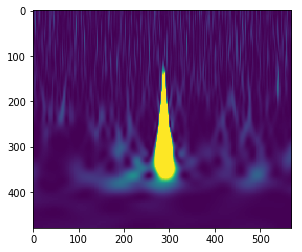

In [ ]:
fullpath = train_dir + 'Blip/' + os.listdir(train_dir + 'Blip')[0]
img=mpimg.imread(fullpath)
plt.imshow(img)

Get the class names,

In [ ]:
classes_list = df.label.value_counts().index
classes_list = list(classes_list)

Take a look at examples of all the 22 classes,

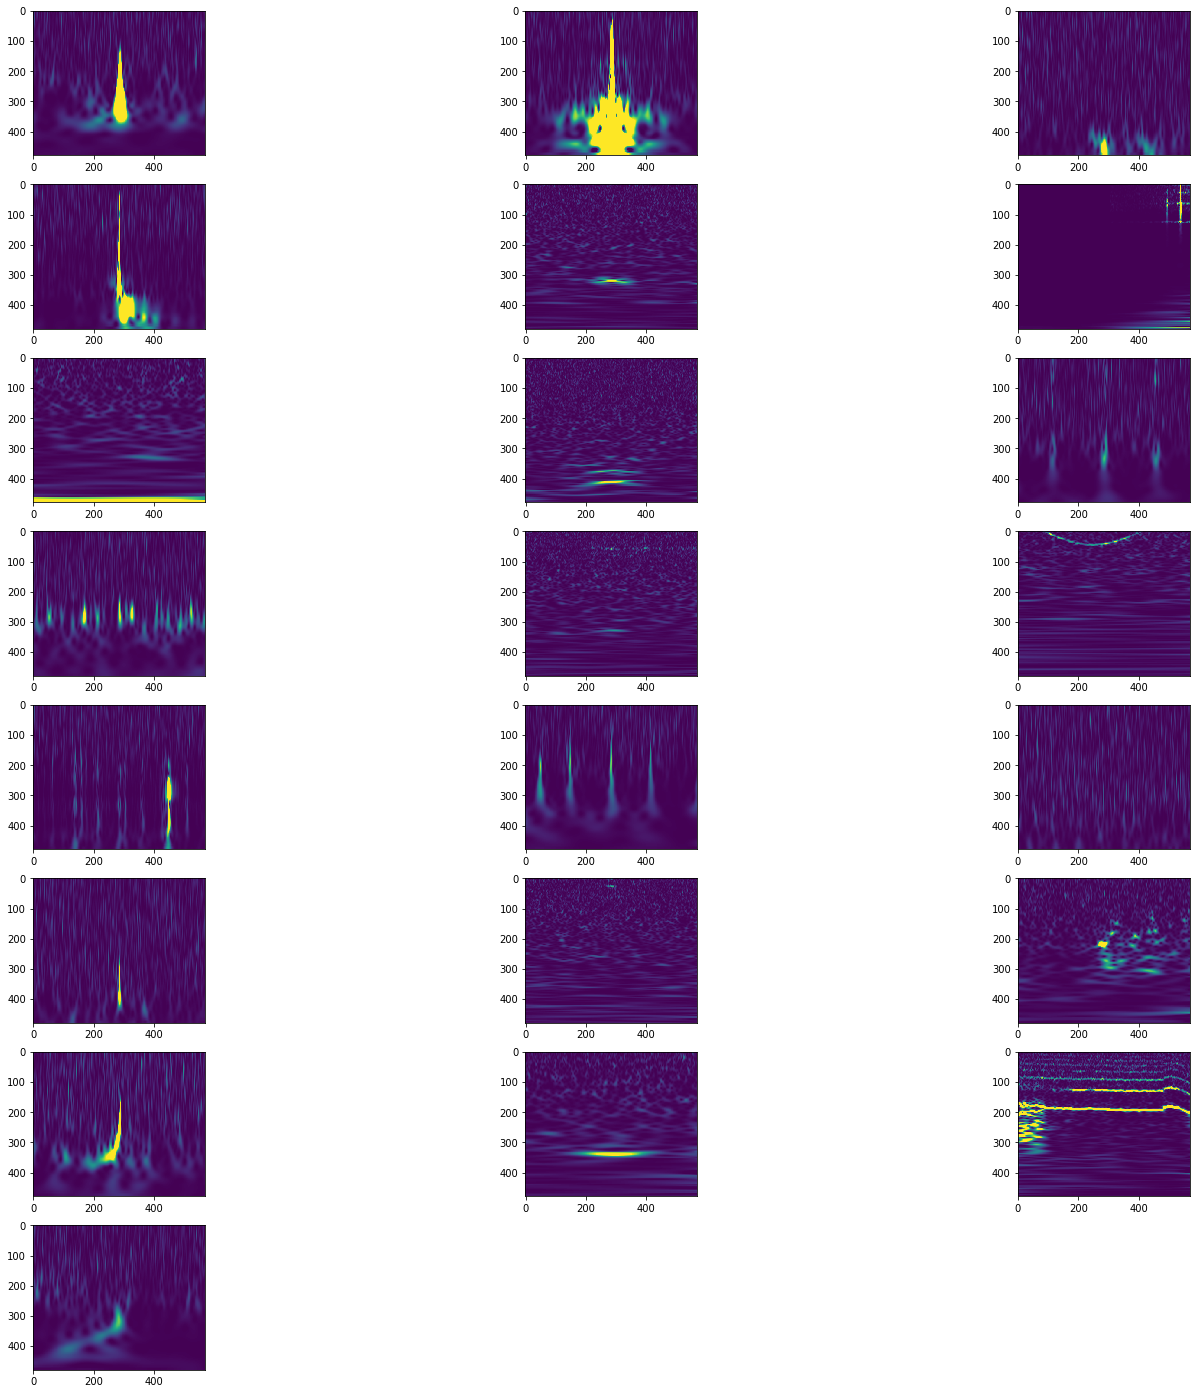

In [ ]:
plt.figure(figsize=(25, 25))

for i in range(0, 22):
    plt.subplot(8, 3, i+1)
    fullpath = train_dir + classes_list[i] + '/' + os.listdir(train_dir + classes_list[i])[0]
    img=mpimg.imread(fullpath)
    plt.imshow(img)

## Keras Model

Let's start to create the model. First, the data sources,

In [ ]:
training_batch_size = 64
validation_batch_size = 32
img_dim = 250

train_generator = train_datagen.flow_from_directory(
  train_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 22348 images belonging to 22 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 4800 images belonging to 22 classes.


In [ ]:
test_size = !find '../input/gravity-spy-gravitational-waves/test/test/' -type f | wc -l
test_size = int(test_size[0])
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 4720 images belonging to 22 classes.


Next, we create the actual CNN,

In [ ]:
input_shape = (img_dim, img_dim, 3)

model = Sequential()
model.add(tf.keras.layers.Conv2D(32, (10, 10), input_shape=input_shape))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(32, (5, 5)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(img_dim, activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(22, activation="softmax"))

Now, train the model,

In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer = 'adam',
              metrics=["accuracy"])

training_step_size = 32
validation_step_size = 32

history = model.fit_generator(
  train_generator,
  steps_per_epoch = training_step_size,
  epochs = 20,
  validation_data = validation_generator,
  validation_steps = validation_step_size,
  verbose = 1)

Epoch 1/20
32/32 [==============================] - 49s 2s/step - loss: 2.5567 - accuracy: 0.2905 - val_loss: 1.8190 - val_accuracy: 0.5752
Epoch 2/20
32/32 [==============================] - 35s 1s/step - loss: 1.5519 - accuracy: 0.6191 - val_loss: 1.2815 - val_accuracy: 0.7002
Epoch 3/20
32/32 [==============================] - 35s 1s/step - loss: 1.0855 - accuracy: 0.7051 - val_loss: 0.8116 - val_accuracy: 0.7939
Epoch 4/20
32/32 [==============================] - 35s 1s/step - loss: 0.8230 - accuracy: 0.7734 - val_loss: 0.6668 - val_accuracy: 0.7979
Epoch 5/20
32/32 [==============================] - 35s 1s/step - loss: 0.7250 - accuracy: 0.8011 - val_loss: 0.5852 - val_accuracy: 0.8281
Epoch 6/20
32/32 [==============================] - 35s 1s/step - loss: 0.6749 - accuracy: 0.8237 - val_loss: 0.5494 - val_accuracy: 0.8623
Epoch 7/20
32/32 [==============================] - 35s 1s/step - loss: 0.5785 - accuracy: 0.8311 - val_loss: 0.5059 - val_accuracy: 0.8506
Epoch 8/20
32/32 [==

Take a look at the accuracy and loss,

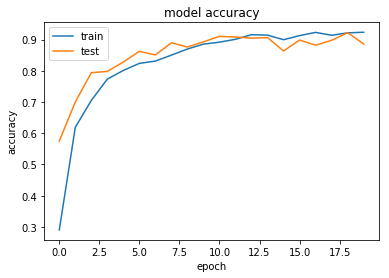

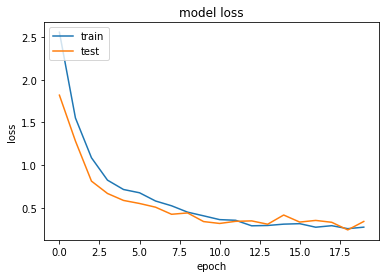

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Make the predictions on the test set,

In [ ]:
predictions = model.predict_generator(test_generator, steps = test_size, verbose = 1)

4720/4720 [==============================] - 87s 18ms/step


Create a confusion matrix,

In [ ]:
df = pd.DataFrame(predictions)
df['filename'] = test_generator.filenames
df['truth'] = ''
df['truth'] = df['filename'].str.split('/', 1, expand = True)
df['prediction_index'] = df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]].idxmax(axis=1)

df['prediction'] = ''

for i in range(0,22):
    df['prediction'][df['prediction_index'] == i] = classes_list[i]

cm = confusion_matrix(df['truth'], df['prediction'])

cm_df = pd.DataFrame(cm)

cm_df.columns = classes_list
cm_df['signal'] = classes_list

cm_df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Blip  Koi_Fish  Low_Frequency_Burst  Light_Modulation  Power_Line  \
0    188         4                    0                 0           0   
1      0        35                    0                 0           0   
2      0         0                   32                 0           0   
3      0         0                    0              1074           0   
4      0         0                    0                 3          37   
5      0         0                    0                 0           0   
6      0         0                    0                 1           0   
7      0         0                    0                11           0   
8      0         0                    0                14           0   
9      0         0                    0                 0           0   
10     0         0                    0                 0           0   
11     0         0                    0                 0           0   
12     0         0                    1                 2           0   
13     0         0                    0                 2           0   
14     0         0                    0                 0           0   
15     0         0                    0                44           1   
16     0         0                    0                 0           0   
17     0         0                    0                 0           0   
18     0         0                    0                31           0   
19     0         0                    0                 1           0   
20     4         0                    0                 0           0   
21     3         1                    0                 3           0   

    Extremely_Loud  Low_Frequency_Lines  Scattered_Light  Violin_Mode  \
0                0                    2                0            0   
1                0                    0                0            0   
2                0                    0                0            0   
3                0                    0                2            1   
4                0                    0                0            0   
5              239                    0               11            0   
6                0                  161                0            0   
7                9                    0              387            0   
8                1                    3                1          271   
9                0                    0                0            5   
10               0                    0                0            0   
11               4                    0                0            0   
12               0                    2                0            4   
13               8                    0                0            2   
14               0                    0                0            0   
15               0                    2                0            1   
16               0                    0                0            0   
17               0                    0                0            0   
18               0                    0                2            0   
19               0                    0                0            0   
20               0                    0                0            0   
21               0                    0                0            0   

    Scratchy  ...  Repeating_Blips  No_Glitch  Tomte  1400Ripples  \
0          0  ...                0          0      0            0   
1          0  ...                0          0      0            0   
2          0  ...                0          4      0            0   
3          0  ...                0          0      0            0   
4          0  ...                0          0      0            0   
5          0  ...                0          0      0            0   
6          0  ...                0          0      1            0   
7          0  ...                0          0      1            0   
8          4  ...      

Plot the confusion matrix as a correlation plot,

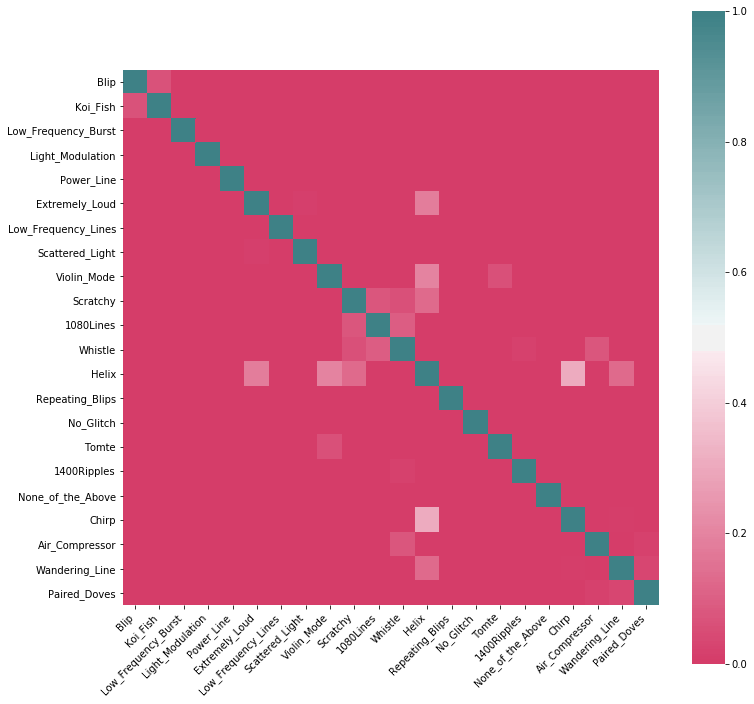

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 12))

corr = cm_df.corr()
ax = sns.heatmap(
    corr,
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(0, 200, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

As you can see, the model is getting the majority of classes correct.

Finally, check the overall accuracy,

In [ ]:
accuracy = accuracy_score(df['truth'], df['prediction'])
accuracy

0.9150423728813559

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
train_dir = '../input/gravity-spy-gravitational-waves/train/train/'
test_dir = '../input//gravity-spy-gravitational-waves/test/test/'
validation_dir = '../input//gravity-spy-gravitational-waves/validation/validation/'

In [ ]:
class_names = os.listdir(train_dir)

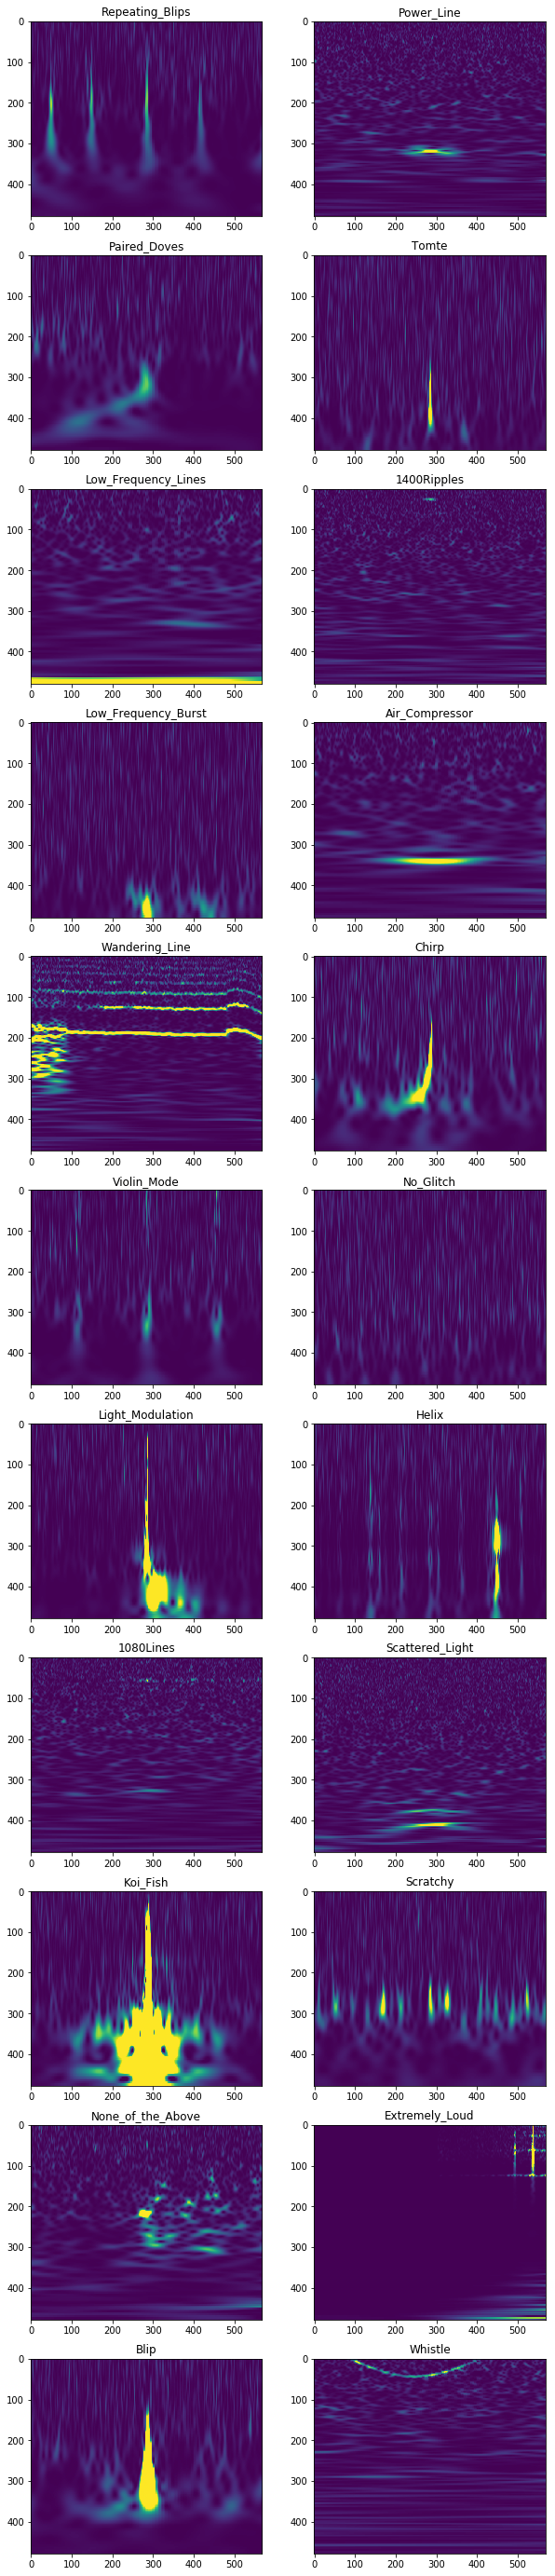

In [ ]:
plt.figure(figsize=(10,50))
for fold, i in zip(class_names,range(0,len(class_names))):

    plt.subplot(11,2, i+1)
    img_read = plt.imread(train_dir+fold+'/'+os.listdir(train_dir+fold)[0])
    plt.imshow(img_read)
    plt.title(class_names[i])

plt.show()

In [ ]:
Batch_size = 128

tr_gen = ImageDataGenerator(rescale = 1./255.,
                           samplewise_center=True,
                           samplewise_std_normalization=True)

val_gen =  ImageDataGenerator(rescale = 1./255.,
                           samplewise_center=True,
                           samplewise_std_normalization=True)

ts_gen =  ImageDataGenerator(rescale = 1./255.,
                           samplewise_center=True,
                           samplewise_std_normalization=True)

In [ ]:
tr_gen = tr_gen.flow_from_directory(train_dir,
                                  batch_size=Batch_size,
                                  classes=class_names,
                                  class_mode='categorical',
                                  shuffle=True,
                                  target_size=(300,300),
                                  seed= 42)

Found 22348 images belonging to 22 classes.


In [ ]:
val_gen = val_gen.flow_from_directory(validation_dir,
                                      batch_size=Batch_size,
                                      classes=class_names,
                                      class_mode='categorical',
                                      shuffle=True,
                                      target_size=(300,300),
                                      seed= 42)

Found 4800 images belonging to 22 classes.


In [ ]:
ts_gen = ts_gen.flow_from_directory(test_dir,
                                  batch_size=Batch_size,
                                  classes=class_names,
                                  class_mode='categorical',
                                  shuffle=False,
                                  target_size=(300,300),
                                  seed= 42)

Found 4720 images belonging to 22 classes.


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='valid', strides=(2,2), activation = 'tanh', input_shape = (300,300,3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='valid', strides=(2,2), activation = 'tanh'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(22, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 149, 149, 128)     3584      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 36, 36, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 22)                912406    
Total params: 1,063,574
Trainable params: 1,063,574
Non-trainable params: 0
____________________________________________

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.01),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss',mode='min',patience=3,verbose=1)
RLr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 2, verbose = 1, min_delta=1e-3,min_lr=1e-6)

history= model.fit(tr_gen,
                 epochs=20,
                 steps_per_epoch=tr_gen.n/Batch_size,
                 validation_data=val_gen,
                 validation_steps=val_gen.n/Batch_size,
                 callbacks=[es,RLr])

Train for 174.59375 steps, validate for 37.5 steps
Epoch 1/20
175/174 [==============================] - 400s 2s/step - loss: 150.7558 - accuracy: 0.4036 - val_loss: 19.9215 - val_accuracy: 0.6127
Epoch 2/20
175/174 [==============================] - 336s 2s/step - loss: 17.0149 - accuracy: 0.7030 - val_loss: 17.0694 - val_accuracy: 0.7692
Epoch 3/20
175/174 [==============================] - 339s 2s/step - loss: 11.2054 - accuracy: 0.7855 - val_loss: 10.2523 - val_accuracy: 0.8117
Epoch 4/20
175/174 [==============================] - 341s 2s/step - loss: 9.7473 - accuracy: 0.8066 - val_loss: 13.6149 - val_accuracy: 0.7450
Epoch 5/20
175/174 [==============================] - 340s 2s/step - loss: 8.1311 - accuracy: 0.8325 - val_loss: 8.5713 - val_accuracy: 0.8529
Epoch 6/20
175/174 [==============================] - 336s 2s/step - loss: 12.0291 - accuracy: 0.8219 - val_loss: 17.2990 - val_accuracy: 0.7806
Epoch 7/20
174/174 [============================>.] - ETA: 0s - loss: 8.4806 - ac

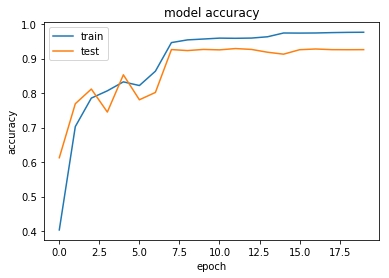

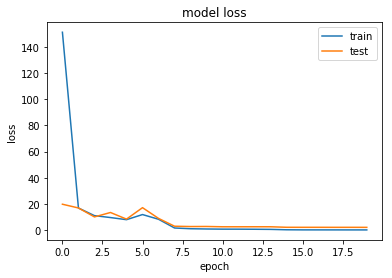

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

preditions

In [ ]:
Y_pred = model.predict(ts_gen,steps=np.ceil(ts_gen.n/Batch_size))
Y_pred = np.argmax(Y_pred, axis=1)
Y_ts = ts_gen.classes

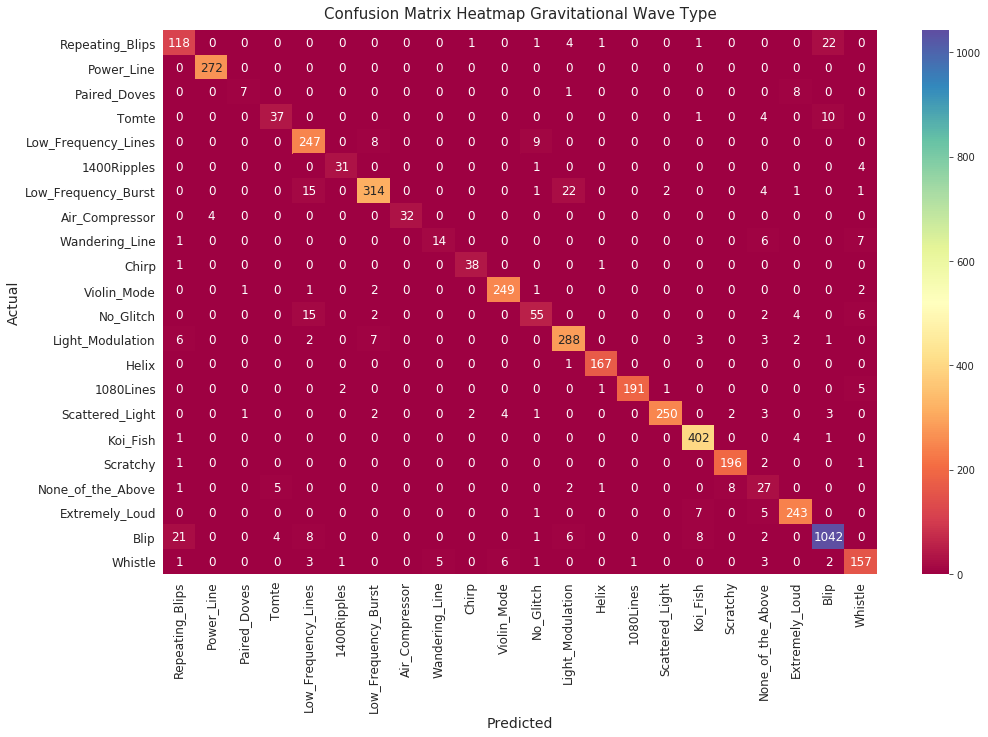

-Accuracy achieved: 92.73%
-Accuracy by model: 97.62%
-Accuracy by validation: 92.58%


In [ ]:
conf_mat = confusion_matrix(Y_ts,Y_pred)
sns.set_style(style='white')
plt.figure(figsize=(16,10))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":12},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap Gravitational Wave Type', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(class_names, fontdict={'fontsize':12,'rotation': 90})
heatmap.set_yticklabels(class_names, fontdict={'fontsize':12,'rotation': 0})
plt.show()

print('-Accuracy achieved: {:.2f}%\n-Accuracy by model: {:.2f}%\n-Accuracy by validation: {:.2f}%'.
      format(accuracy_score(Y_ts,Y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))

Errors Sample

In [ ]:
index=0
index_errors= []

for label, predict in zip(Y_ts,Y_pred):
    if label != predict:
        index_errors.append(index)
    index +=1

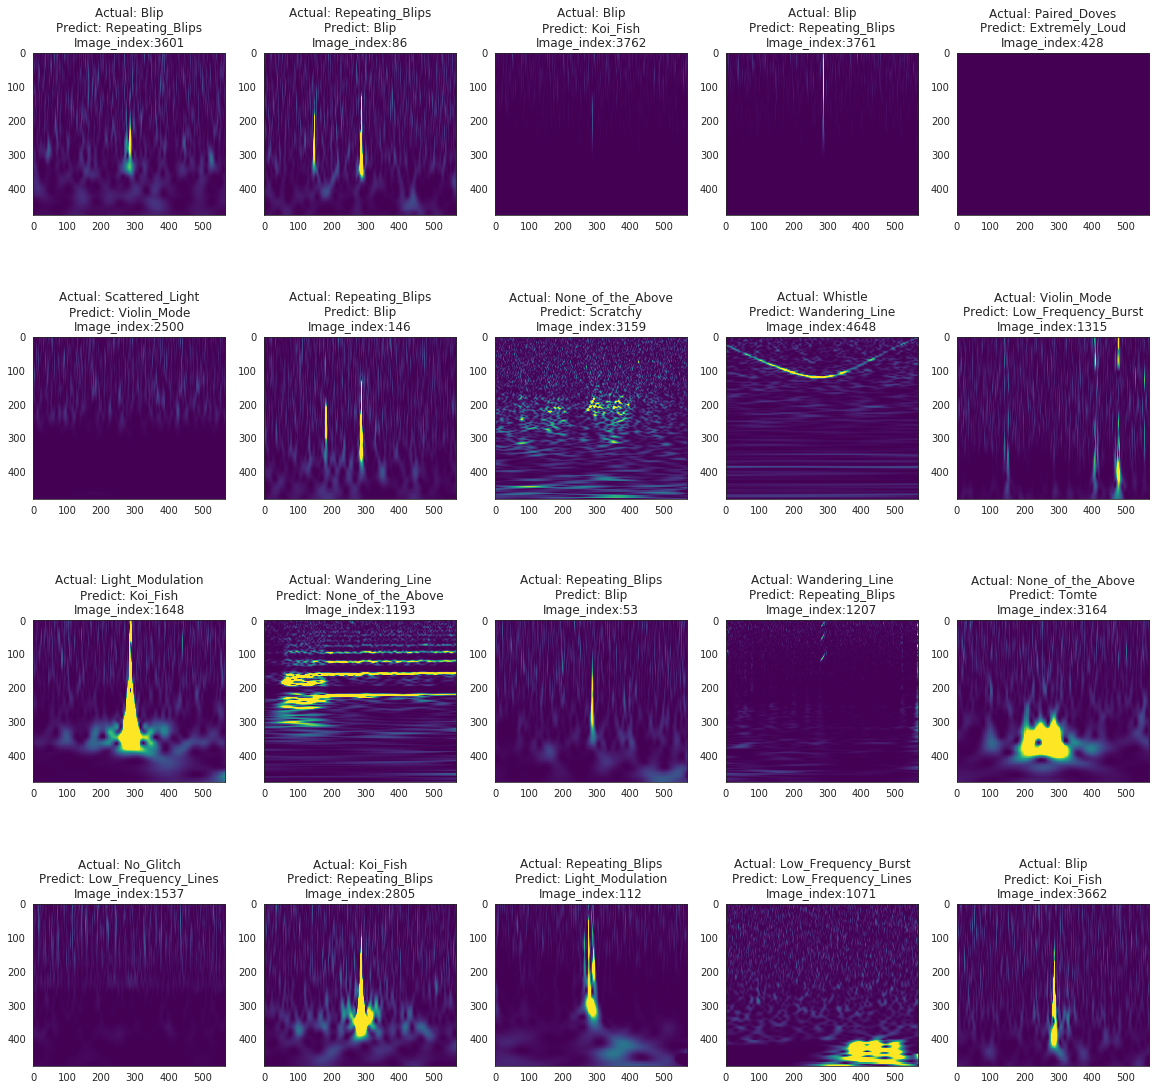

In [ ]:
plt.figure(figsize=(20,20))

for i,img_index in zip(range(1,21),random.sample(index_errors,k=20)):
    plt.subplot(4,5,i)
    img_read = plt.imread(ts_gen.filepaths[img_index])
    plt.imshow(img_read)
    plt.title('Actual: '+str(class_names[Y_ts[img_index]])+'\nPredict: '+str(class_names[Y_pred[img_index]])+'\nImage_index:'+str(img_index))
plt.show()

Interferometer CNN

What are Gravitational Waves?¶
Gravitational waves are 'ripples' in space-time caused by some of the most violent and energetic processes in the Universe. Albert Einstein predicted the existence of gravitational waves in 1916 in his general theory of relativity. Einstein's mathematics showed that massive accelerating objects (such as neutron stars or black holes orbiting each other) would disrupt space-time in such a way that 'waves' of undulating space-time would propagate in all directions away from the source. These cosmic ripples would travel at the speed of light, carrying with them information about their origins, as well as clues to the nature of gravity itself.

The strongest gravitational waves are produced by cataclysmic events such as colliding black holes, supernovae (massive stars exploding at the end of their lifetimes), and colliding neutron stars. Other waves are predicted to be caused by the rotation of neutron stars that are not perfect spheres, and possibly even the remnants of gravitational radiation created by the Big Bang.

Reading lines is a tedious works! Nobody should be tasked for it¶
Sometimes it is just a random fishing boat signal, not a merging blackhole

In [ ]:
import matplotlib.image as img
import matplotlib.pyplot as plt

power line example

In [ ]:
sample = img.imread('/kaggle/input/gravity-spy-gravitational-waves/train/train/Power_Line/H1_9wlnDo4Vtg_spectrogram_4.0.png')

(479, 569, 4)


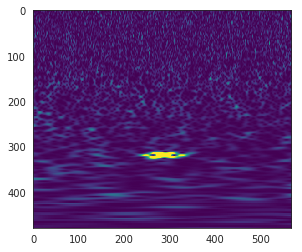

In [ ]:
plt.imshow(sample)
print(sample.shape)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
TRAINING_DIR = '/kaggle/input/gravity-spy-gravitational-waves/train/train/'
training_datagen = ImageDataGenerator(rescale = 1./255)

VALIDATION_DIR = '/kaggle/input/gravity-spy-gravitational-waves/validation/validation/'
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
sample.shape[0]

479

In [ ]:
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(sample.shape[0],sample.shape[1]),
    batch_size = 32,
	class_mode='categorical',
  shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(sample.shape[0],sample.shape[1]),
    batch_size = 32,
	class_mode='categorical',
  shuffle=True
)

Found 22348 images belonging to 22 classes.
Found 4800 images belonging to 22 classes.


Enumerating the labels¶

In [ ]:
train_generator.class_indices

{'1080Lines': 0,
 '1400Ripples': 1,
 'Air_Compressor': 2,
 'Blip': 3,
 'Chirp': 4,
 'Extremely_Loud': 5,
 'Helix': 6,
 'Koi_Fish': 7,
 'Light_Modulation': 8,
 'Low_Frequency_Burst': 9,
 'Low_Frequency_Lines': 10,
 'No_Glitch': 11,
 'None_of_the_Above': 12,
 'Paired_Doves': 13,
 'Power_Line': 14,
 'Repeating_Blips': 15,
 'Scattered_Light': 16,
 'Scratchy': 17,
 'Tomte': 18,
 'Violin_Mode': 19,
 'Wandering_Line': 20,
 'Whistle': 21}

CNN

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image

In [ ]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(sample.shape[0],sample.shape[1],3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(22, activation='softmax')
])

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 477, 567, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 238, 283, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 236, 281, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 118, 140, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 116, 138, 128)     73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 58, 69, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 67, 128)      

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(patience=2)

history = model.fit_generator(train_generator, epochs=50,
                              validation_data = validation_generator, validation_steps = 32,
                              verbose = 1, steps_per_epoch = 32, callbacks=[callbacks])

Epoch 1/50
32/32 [==============================] - 47s 1s/step - loss: 14.6419 - accuracy: 0.0654 - val_loss: 15.1422 - val_accuracy: 0.0605
Epoch 2/50
32/32 [==============================] - 45s 1s/step - loss: 15.3153 - accuracy: 0.0498 - val_loss: 15.1422 - val_accuracy: 0.0605
Epoch 3/50
32/32 [==============================] - 45s 1s/step - loss: 15.0635 - accuracy: 0.0654 - val_loss: 15.1422 - val_accuracy: 0.0605


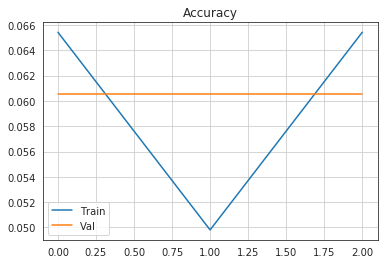

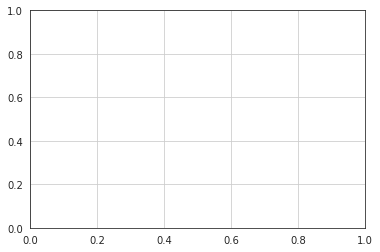

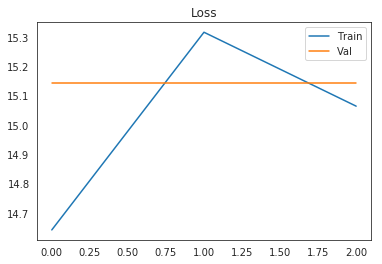

In [ ]:
plt.grid()

plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Val')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.grid()
plt.figure()
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Val')
plt.title('Loss')
plt.legend()

Evaluate the Test Data

In [ ]:
TEST_DIR = '/kaggle/input/gravity-spy-gravitational-waves/test/test/'
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
	TEST_DIR,
	target_size=(sample.shape[0],sample.shape[1]),
    batch_size = 1,
	class_mode='categorical',
  shuffle=False
)

Found 4720 images belonging to 22 classes.


The prediction is how most likely each image related to a class of signal

In [ ]:
prediction = model.predict_generator(test_generator, steps = 4720 , verbose = 1)

4720/4720 [==============================] - 66s 14ms/step


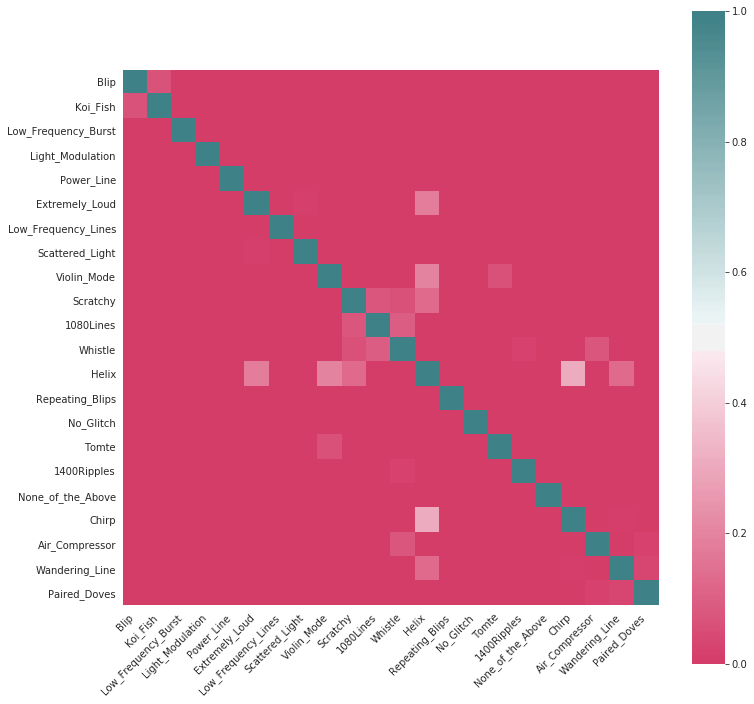

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 12))

corr = cm_df.corr()
ax = sns.heatmap(
    corr,
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(0, 200, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


In [ ]:
accuracy = accuracy_score(df['truth'], df['prediction'])
accuracy

0.9150423728813559

NEW CNN

In [ ]:
model = models.Sequential()

# Input and Conv1
model.add(layers.Conv2D(filters=4, kernel_size=(3,3), strides=(2,2),
                        activation = 'relu', padding='valid',
                        input_shape = (300,300,3)))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

#Conv2

model.add(layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2),
                       activation='relu', padding='valid'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

#Conv3

model.add(layers.Conv2D(filters=32, kernel_size=(3,3),dilation_rate=(2,2),
                       activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3,3),
                       activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D(strides=3))
model.add(layers.BatchNormalization())

#Flattening and Fully Connected

model.add(layers.Flatten())

model.add(layers.Dense(200, activation= 'relu'))
model.add(layers.Dense(100, activation= 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())

# Output
model.add(layers.Dense(22, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 149, 149, 4)       112       
_________________________________________________________________
dropout_5 (Dropout)          (None, 149, 149, 4)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 4)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 4)         16        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 36, 36, 16)        592       
_________________________________________________________________
dropout_6 (Dropout)          (None, 36, 36, 16)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 18, 16)       

Fitting

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.01),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss',mode='min',patience=3,verbose=1)
RLr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 2, verbose = 1, min_delta=1e-3,min_lr=1e-6)

history= model.fit(tr_gen,
                 epochs=5,
                 steps_per_epoch=tr_gen.n/Batch_size,
                 validation_data=val_gen,
                 validation_steps=val_gen.n/Batch_size,
                 callbacks=[es,RLr])

Train for 174.59375 steps, validate for 37.5 steps
Epoch 1/5
175/174 [==============================] - 363s 2s/step - loss: 0.5601 - accuracy: 0.8343 - val_loss: 0.7695 - val_accuracy: 0.8102
Epoch 2/5
175/174 [==============================] - 344s 2s/step - loss: 0.2719 - accuracy: 0.9174 - val_loss: 0.4337 - val_accuracy: 0.8656
Epoch 3/5
175/174 [==============================] - 330s 2s/step - loss: 0.2113 - accuracy: 0.9357 - val_loss: 0.3393 - val_accuracy: 0.9048
Epoch 4/5
175/174 [==============================] - 326s 2s/step - loss: 0.1767 - accuracy: 0.9483 - val_loss: 0.3871 - val_accuracy: 0.8931
Epoch 5/5
174/174 [============================>.] - ETA: 0s - loss: 0.1550 - accuracy: 0.9541
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
175/174 [==============================] - 325s 2s/step - loss: 0.1552 - accuracy: 0.9541 - val_loss: 0.6496 - val_accuracy: 0.8483


Evaluation

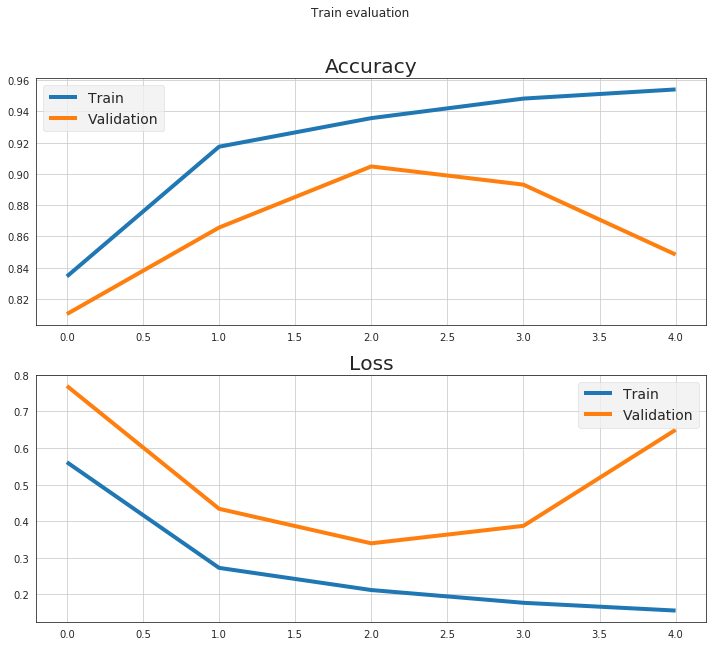

In [ ]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')

with plt.style.context('fivethirtyeight'):

    sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
    sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

    ax[0].legend(['Train','Validation'])
    ax[0].set_title('Accuracy')
    ax[0].grid()

    sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
    sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

    ax[1].legend(['Train','Validation'])
    ax[1].set_title('Loss')
    ax[1].grid()


plt.show()

Predictions

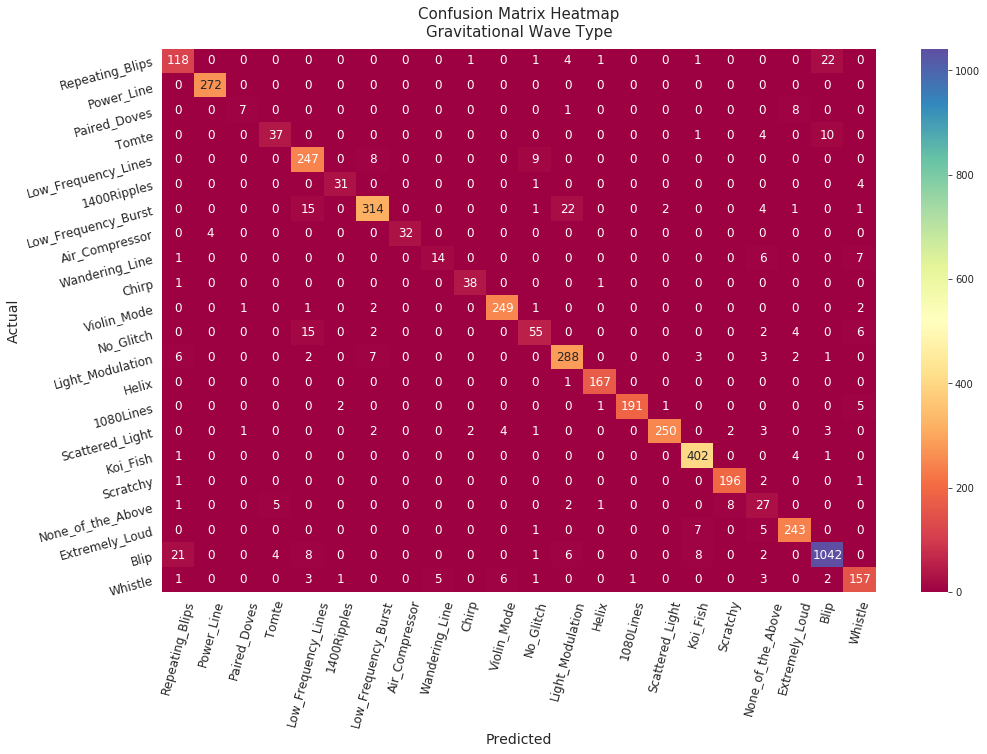

-Accuracy achieved: 92.73%
-Accuracy by model was: 95.41%
-Accuracy by validation was: 84.83%


In [ ]:
conf_mat = confusion_matrix(Y_ts,Y_pred)
sns.set_style(style='dark')
plt.figure(figsize=(16,10))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":12},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap\nGravitational Wave Type', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(class_names, fontdict={'fontsize':12,'rotation': 75})
heatmap.set_yticklabels(class_names, fontdict={'fontsize':12,'rotation': 15})
plt.show()

print('-Accuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(Y_ts,Y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))

Errors Sample

In [ ]:
index=0
index_errors= []

for label, predict in zip(Y_ts,Y_pred):
    if label != predict:
        index_errors.append(index)
    index +=1

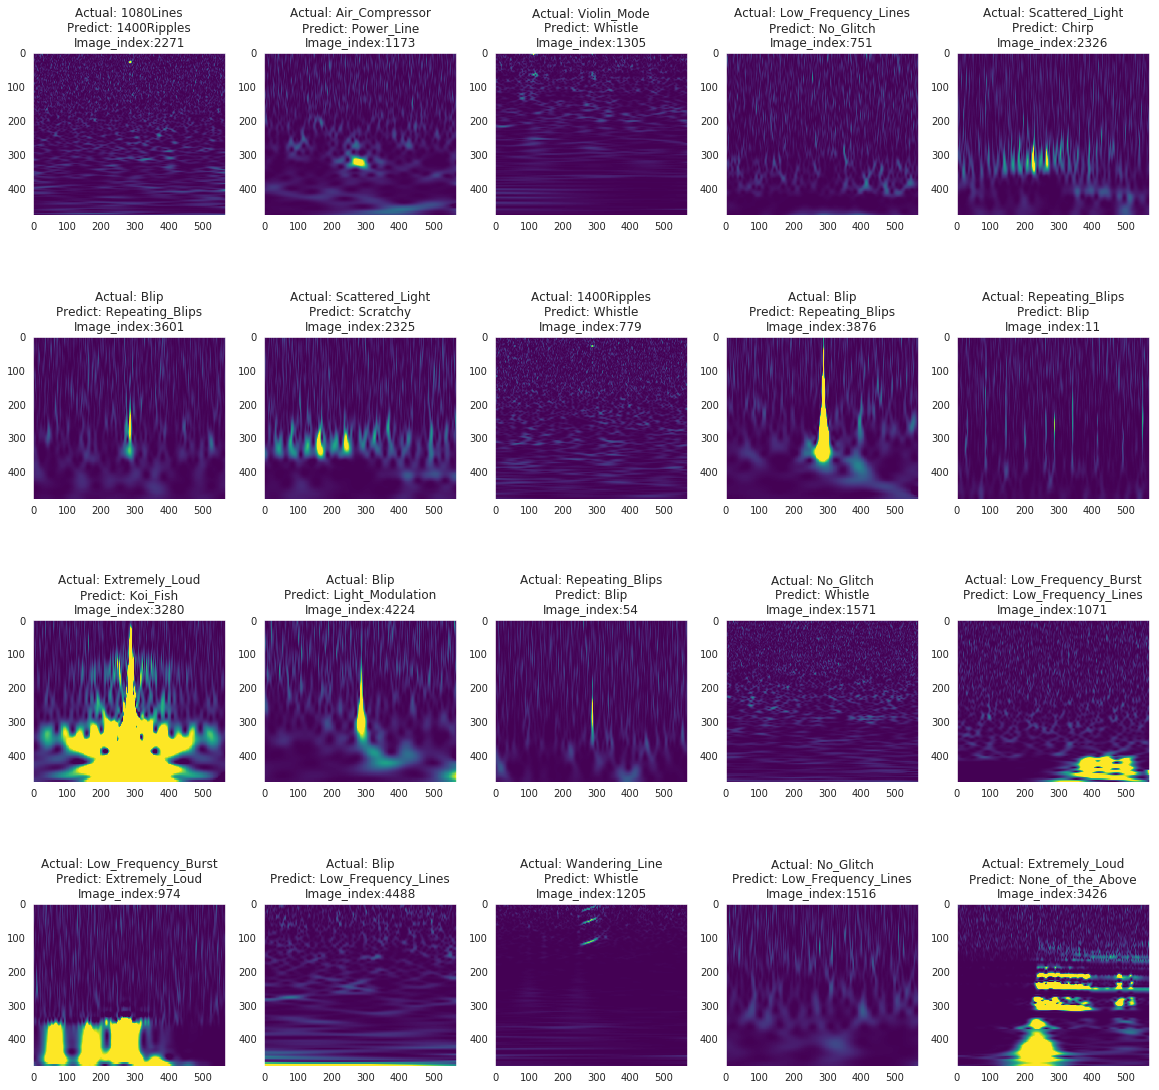

In [ ]:
plt.figure(figsize=(20,20))

for i,img_index in zip(range(1,21),random.sample(index_errors,k=20)):
    plt.subplot(4,5,i)
    img_read = plt.imread(ts_gen.filepaths[img_index])
    plt.imshow(img_read)
    plt.title('Actual: '+str(class_names[Y_ts[img_index]])+'\nPredict: '+str(class_names[Y_pred[img_index]])+'\nImage_index:'+str(img_index))
plt.show()

In [ ]:
# Load libraries
import numpy as np
np.random.seed(1)
import tensorflow as tf

from tensorflow.keras.models import Sequential, save_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import time
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from keras.preprocessing import image

import matplotlib.image as mpimg

plt.rcParams.update({'figure.max_open_warning': 0})

# Required line to avoid issue issue https://github.com/slundberg/shap/issues/1694#issue-773518362
tf.compat.v1.disable_v2_behavior()

In [ ]:
#Time measure
total_start_time = time.time()
# Cofig variables
LOAD_MODEL = True
SAVE_MODEL = False
TEST_MODEL = True
RUN_CONFUSION_MATRIX = True
RUN_TENSORBOARD = False
CLEAR_TENSORBOARD_LOGS = False
ZIP_RESULTS = False
RUN_SHAP = True
RUN_SALIENCY_MAPS = False
FREE_GPU_MEMORY = False

In [ ]:
# Point to the 3 directories
train_dir = '../input/gravity-spy-gravitational-waves/train/train/'
validation_dir = '../input/gravity-spy-gravitational-waves/validation/validation/'
test_dir = '../input/gravity-spy-gravitational-waves/test/test/'

In [ ]:
# Create the data generators
train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
# Test if GPU is available
device_name = tf.test.gpu_device_name()
print('GPU avaliable: ', device_name)
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

GPU avaliable:  /device:GPU:0


In [ ]:
# Take a look at the dataset
df = pd.read_csv("../input/gravity-spy-gravitational-waves/trainingset_v1d1_metadata.csv")
pd.set_option('display.max_rows', None)
# Print number of rows per label in dataset
print(df['label'].value_counts().sort_index(ascending=True), '\n')
# Print number of rows per sample_type in dataset
print(df['sample_type'].value_counts().sort_index(ascending=True), '\n')
# Print count of rows per label and sample_type
print(df.groupby(['label', 'sample_type']).size())
pd.set_option('display.max_rows', 10)

1080Lines               328
1400Ripples              81
Air_Compressor           58
Blip                   1821
Chirp                    60
Extremely_Loud          447
Helix                   279
Koi_Fish                706
Light_Modulation        512
Low_Frequency_Burst     621
Low_Frequency_Lines     447
No_Glitch               150
None_of_the_Above        81
Paired_Doves             27
Power_Line              449
Repeating_Blips         263
Scattered_Light         443
Scratchy                337
Tomte                   103
Violin_Mode             412
Wandering_Line           42
Whistle                 299
Name: label, dtype: int64 

test          1179
train         5587
validation    1200
Name: sample_type, dtype: int64 

label                sample_type
1080Lines            test             50
                     train           229
                     validation       49
1400Ripples          test              9
                     train            59
                     valida

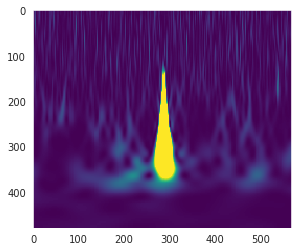

In [ ]:
# The most common type is 'Blip'. Here is what such an image looks like
fullpath = train_dir + 'Blip/' + os.listdir(train_dir + 'Blip')[0]
img=mpimg.imread(fullpath)
plt.imshow(img)

In [ ]:
# Get the class names
classes_list = df.label.value_counts().index
classes_list = list(classes_list)

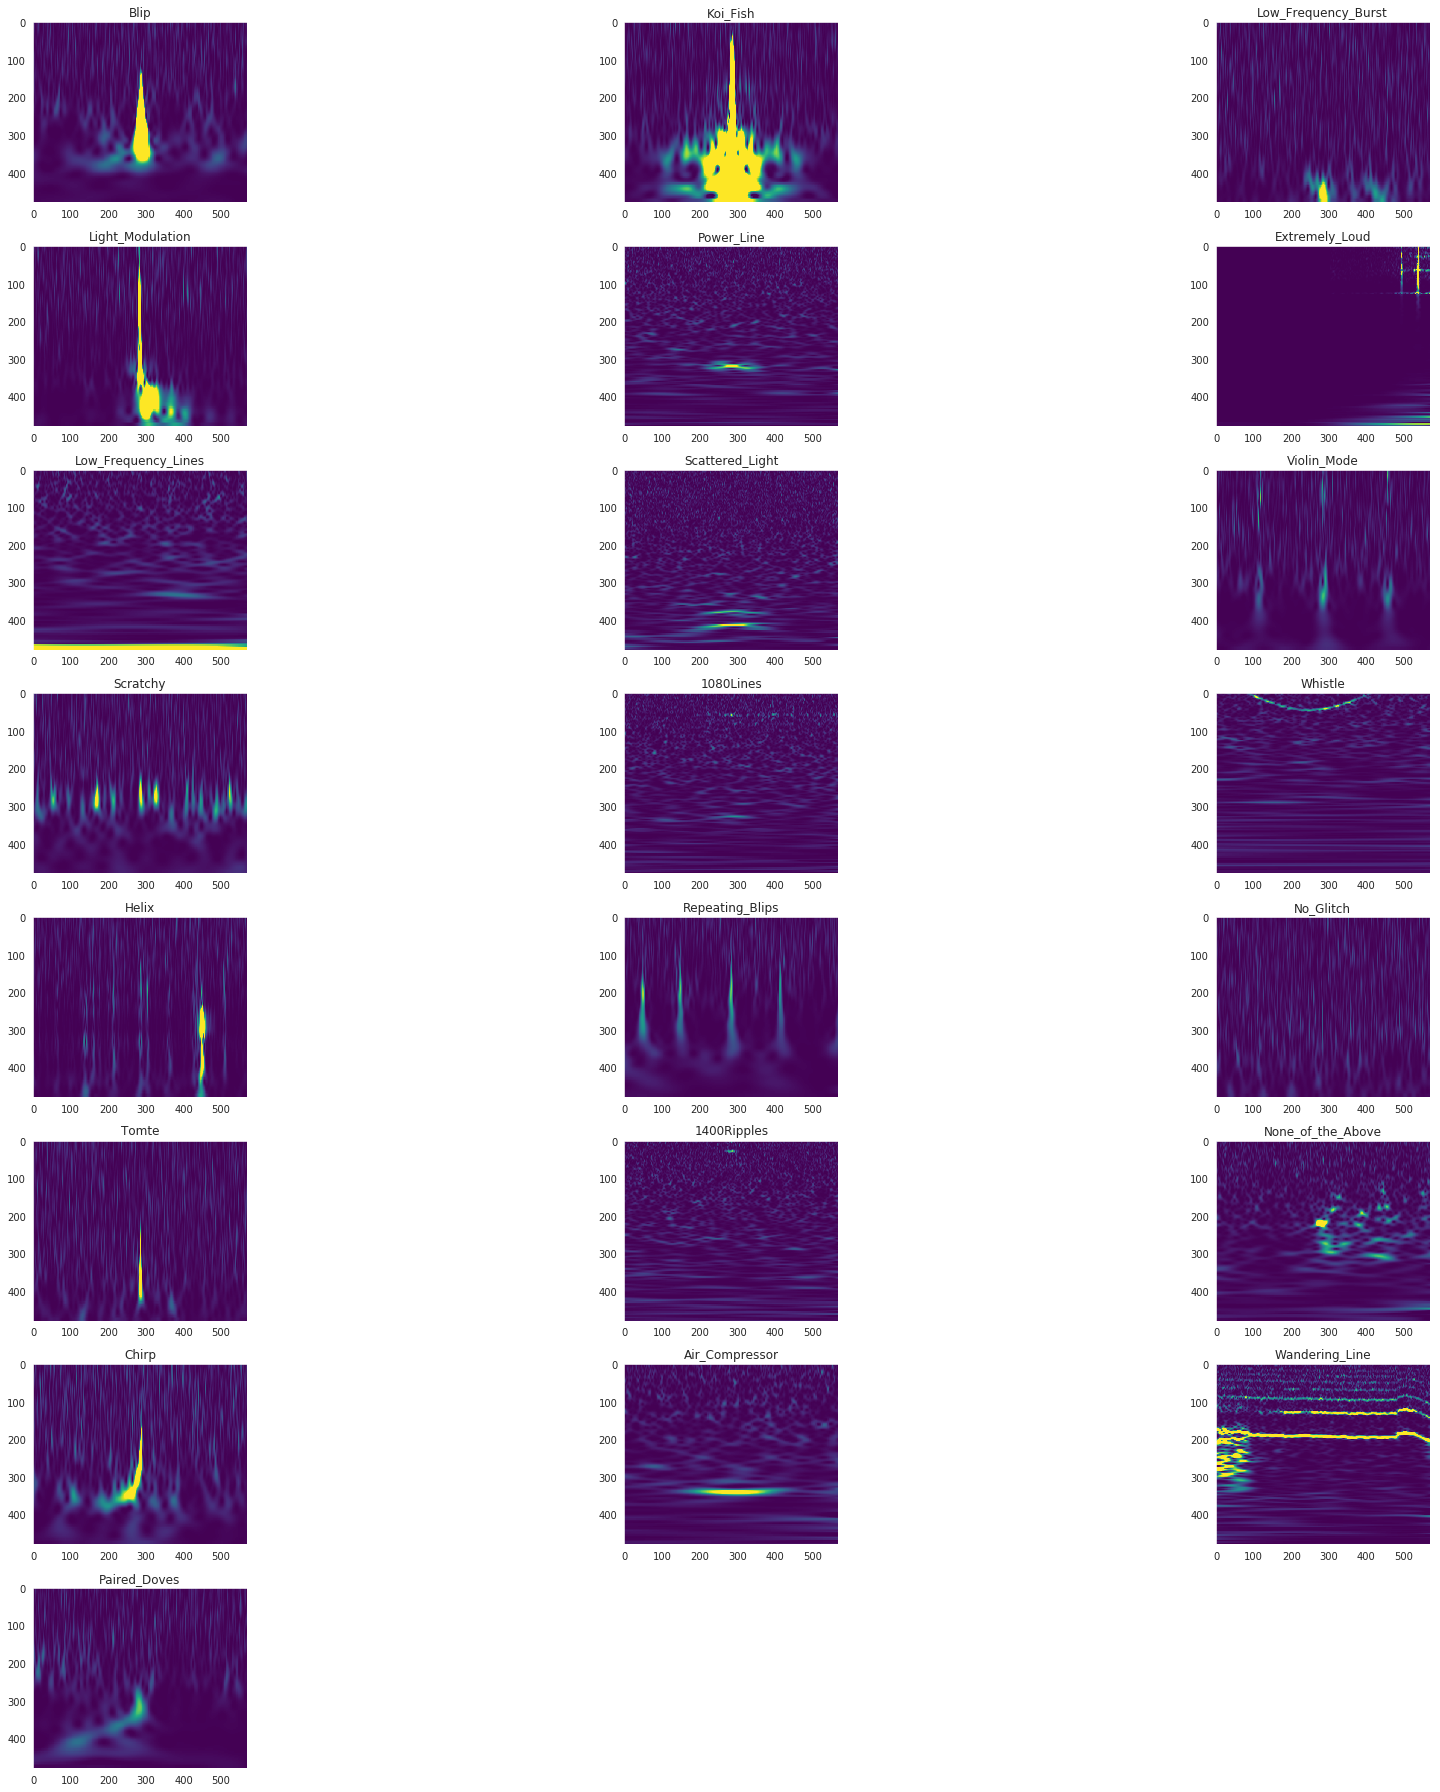

In [ ]:
# Examples of all the 22 classes
plt.figure(figsize=(25, 25))

for i in range(0, 22):
    plt.subplot(8, 3, i+1)
    fullpath = train_dir + classes_list[i] + '/' + os.listdir(train_dir + classes_list[i])[0]
    img=mpimg.imread(fullpath)
    plt.title(classes_list[i])
    plt.tight_layout()
    plt.imshow(img)

In [ ]:
# Data sources
training_batch_size = 64
validation_batch_size = 32
img_dim = 250

train_generator = train_datagen.flow_from_directory(
  train_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

test_size = !find '../input/gravity-spy-gravitational-waves/test/test/' -type f | wc -l
test_size = int(test_size[0])
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  classes = classes_list,
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False,
  seed = 3)

Found 22348 images belonging to 22 classes.
Found 4800 images belonging to 22 classes.
Found 4720 images belonging to 22 classes.


In [ ]:
if TEST_MODEL:
    # Accuracy
    df = pd.DataFrame(predictions)
    df['filename'] = test_generator.filenames
    df['truth'] = np.nan
    df['truth'] = df['filename'].str.split('/', 1, expand = True)
    df['prediction_index'] = df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]].idxmax(axis=1).copy()
    df['prediction'] = np.nan

    for i in range(0,22):
        df['prediction'][df['prediction_index'] == i] = classes_list[i]

    accuracy = accuracy_score(df['truth'], df['prediction'])
    print(accuracy)


0.9150423728813559


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Top values in confusion matrix:
         value       row_index       col_index
165  0.312389           Chirp           Helix
74   0.197672           Helix     Violin_Mode
71   0.176618           Helix  Extremely_Loud
75   0.130356           Helix        Scratchy
202  0.128621  Wandering_Line           Helix
65   0.091608         Whistle       1080Lines
182  0.073367  Air_Compressor         Whistle
54   0.072271       1080Lines        Scratchy
0    0.063850        Koi_Fish            Blip
113  0.061604           Tomte     Violin_Mode


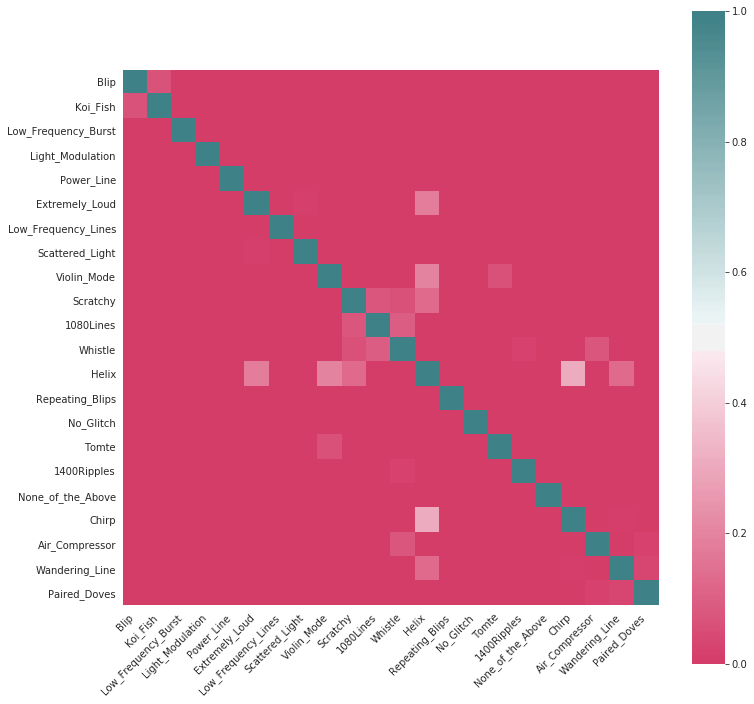

In [ ]:
if TEST_MODEL:
    # Create a confusion matrix
    if RUN_CONFUSION_MATRIX:
        cm = confusion_matrix(df['truth'], df['prediction'])
        cm_df = pd.DataFrame(cm)
        cm_df.columns = classes_list
        cm_df['signal'] = classes_list

        # Plot the confusion matrix as a correlation plot
        import seaborn as sns

        plt.figure(figsize=(12, 12))

        corr = cm_df.corr()
        # Warning raised in this line.
        ax = sns.heatmap(
            corr,
            vmin=0, vmax=1, center=0.5,
            cmap=sns.diverging_palette(0, 200, n=200),
            square=True
        )
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=45,
            horizontalalignment='right'
        )

        # Calculate the N max values and their indexes in confusion matrix
        df_data = {
            'value': [],
            'row_index': [],
            'col_index': []
        }
        num_max_values = 5
        for i in range(len(corr)):
            for j in range(len(corr.iloc[i])):
                end_col = (corr.iloc[i,j] == 1)
                if end_col:
                    break
                df_data['value'].append(corr.iloc[i,j])
                df_data['row_index'].append(corr.iloc[i].index[i])
                df_data['col_index'].append(corr.iloc[i].index[j])
        corr_df = pd.DataFrame(df_data)
        print('Top values in confusion matrix:\n', corr_df.nlargest(10, ['value']))

worst predictions

In [ ]:
# Line declared for use in the next code cells
pivot_table_df = None
worst_predictions_df = None
if TEST_MODEL:
    # Check the number of errors in the model and which predictions the least accurate.
    df['prediction_is_correct'] = df.apply(lambda x : True if x['truth'] == x['prediction'] else False, axis = 1)
    pd.set_option('display.max_rows', None)
    pivot_table_df = pd.pivot_table(df.loc[:,['truth', 'prediction_is_correct']], index=['truth'], \
        columns=['prediction_is_correct'], aggfunc=len, fill_value=0).sort_values(\
        by=False, ascending=False).head()
    print(pivot_table_df, '\n')
    pivot_table_df = pd.pivot_table(df.loc[:,['truth', 'prediction', 'prediction_is_correct']], \
        index=['truth', 'prediction'], columns=['prediction_is_correct'], aggfunc=len, \
        fill_value=0).sort_values(by='truth', ascending=True)
    print(pivot_table_df, '\n')
    pivot_table_df = pd.pivot_table(df.loc[:,['truth', 'prediction', 'prediction_is_correct']], \
        index=['truth', 'prediction'], columns=['prediction_is_correct'], aggfunc=len, \
        fill_value=0).sort_values(by=False, ascending=False).head()
    print(pivot_table_df, '\n')

    # Collect x images from the top worst prediction pairs
    num_images = 5
    df_aux_0 = df[(df.truth == pivot_table_df.index[0][0]) & \
        (df.prediction == pivot_table_df.index[0][1]) & \
        (df.prediction_is_correct == False) & \
        (df.filename.str.contains('4.0.png'))].head(num_images)
    df_aux_1 = df[(df.truth == pivot_table_df.index[1][0]) & \
        (df.prediction == pivot_table_df.index[1][1]) & \
        (df.prediction_is_correct == False) & \
        (df.filename.str.contains('4.0.png'))].head(num_images)
    worst_predictions_df = pd.concat([df_aux_0,df_aux_1], ignore_index=True)
    print(worst_predictions_df[['filename', 'truth', 'prediction', 'prediction_is_correct']])

prediction_is_correct  False  True 
truth                              
Repeating_Blips           57     91
Low_Frequency_Burst       48    312
Light_Modulation          41    271
Tomte                     34     18
Violin_Mode               27    229 

prediction_is_correct                    False  True 
truth               prediction                       
1080Lines           1080Lines                0    188
                    1400Ripples              4      0
                    Helix                    2      0
                    No_Glitch                1      0
                    Whistle                  5      0
1400Ripples         1400Ripples              0     35
                    No_Glitch                1      0
Air_Compressor      Air_Compressor           0     32
                    Power_Line               4      0
Blip                Whistle                  2      0
                    No_Glitch                5      0
                    Low_Frequency_Lines     

Worst Predictions Shapley Values

In [ ]:
# Lines declared for use in the next code cells

if RUN_SHAP:
    # Now explainability analysis
    import shap

    # Preparation
    shap_values = []
    test = []
    shap_train_batch_size = 64
    shap_test_batch_size = 5

    shap_background_generator = train_datagen.flow_from_directory(
            train_dir,
            classes = classes_list,
            target_size = (img_dim, img_dim),
            batch_size = shap_train_batch_size,
            class_mode = "categorical",
            shuffle = True,
            seed = 3)
    shap_test_generator = test_datagen.flow_from_dataframe(
            worst_predictions_df,
            directory = test_dir,
            classes = classes_list,
            y_col = 'truth',
            target_size = (img_dim, img_dim),
            batch_size = shap_test_batch_size,
            class_mode = "categorical",
            shuffle = False,
            seed = 3)


    # Select a set of background examples to take an expectation over
    shap_background = shap_background_generator.next()[0]

    # Select a set to calculate shapley values
    shap_test = shap_test_generator.next()[0]

    # Explain predictions of the model on four images
    print('Creating DeepExplainer...', end='')



    print('completed.')
    print('Calculating shapley values...', end='')

    print('completed.')


Found 22348 images belonging to 22 classes.
Found 10 validated image filenames belonging to 22 classes.
Creating DeepExplainer...completed.
Calculating shapley values...completed.
